['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


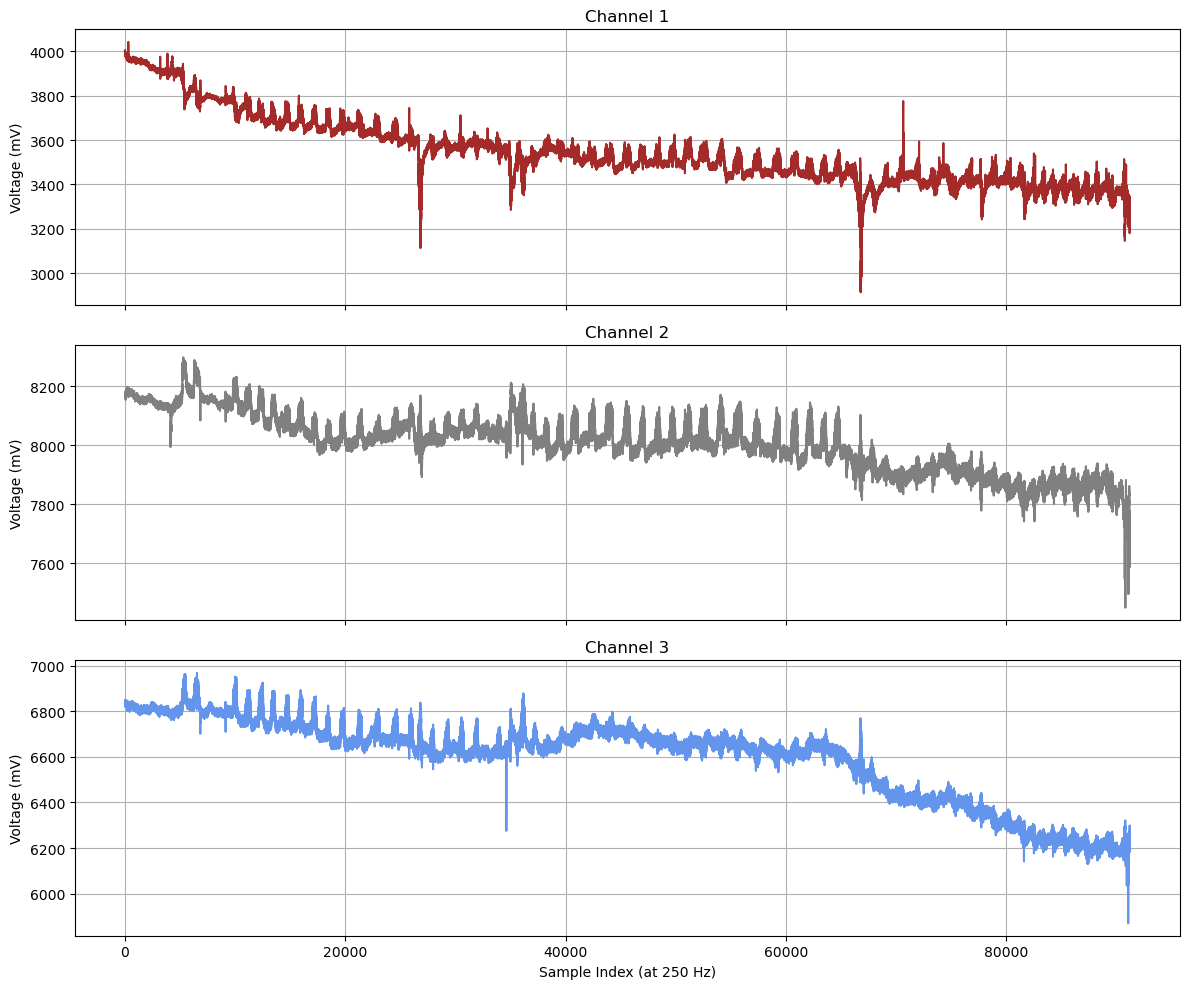

In [37]:
# -------------------------- Visualization of Raw data

import pandas as pd
import matplotlib.pyplot as plt

# Load OpenBCI data
path = "C:/Quick_Disk/tonge_emg_xr_project/data/Recordings/"
file_name = "recording1.csv"
df = pd.read_csv(path + file_name, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df.columns = [f"ch_{i}" for i in range(df.shape[1])]
print(df.columns.tolist())

# Define sampling rate and duration
sampling_rate = 250  # Hz
duration_sec = 20
num_samples = df.shape[0] # sampling_rate * duration_sec  # 5000 samples

# Create subplots
channel_colors = {
    'ch_1': 'brown',
    'ch_2': 'gray',
    'ch_3': '#6495ed'
}
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Channel 1
axs[0].plot(df.iloc[:num_samples, 1], color=channel_colors['ch_1'])
axs[0].set_title("Channel 1")
axs[0].set_ylabel("Voltage (mV)")
axs[0].grid(True)

# Plot Channel 2
axs[1].plot(df.iloc[:num_samples, 2], color=channel_colors['ch_2'])
axs[1].set_title("Channel 2")
axs[1].set_ylabel("Voltage (mV)")
axs[1].grid(True)

# Plot Channel 3
axs[2].plot(df.iloc[:num_samples, 3], color=channel_colors['ch_3'])
axs[2].set_title("Channel 3")
axs[2].set_xlabel("Sample Index (at 250 Hz)")
axs[2].set_ylabel("Voltage (mV)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


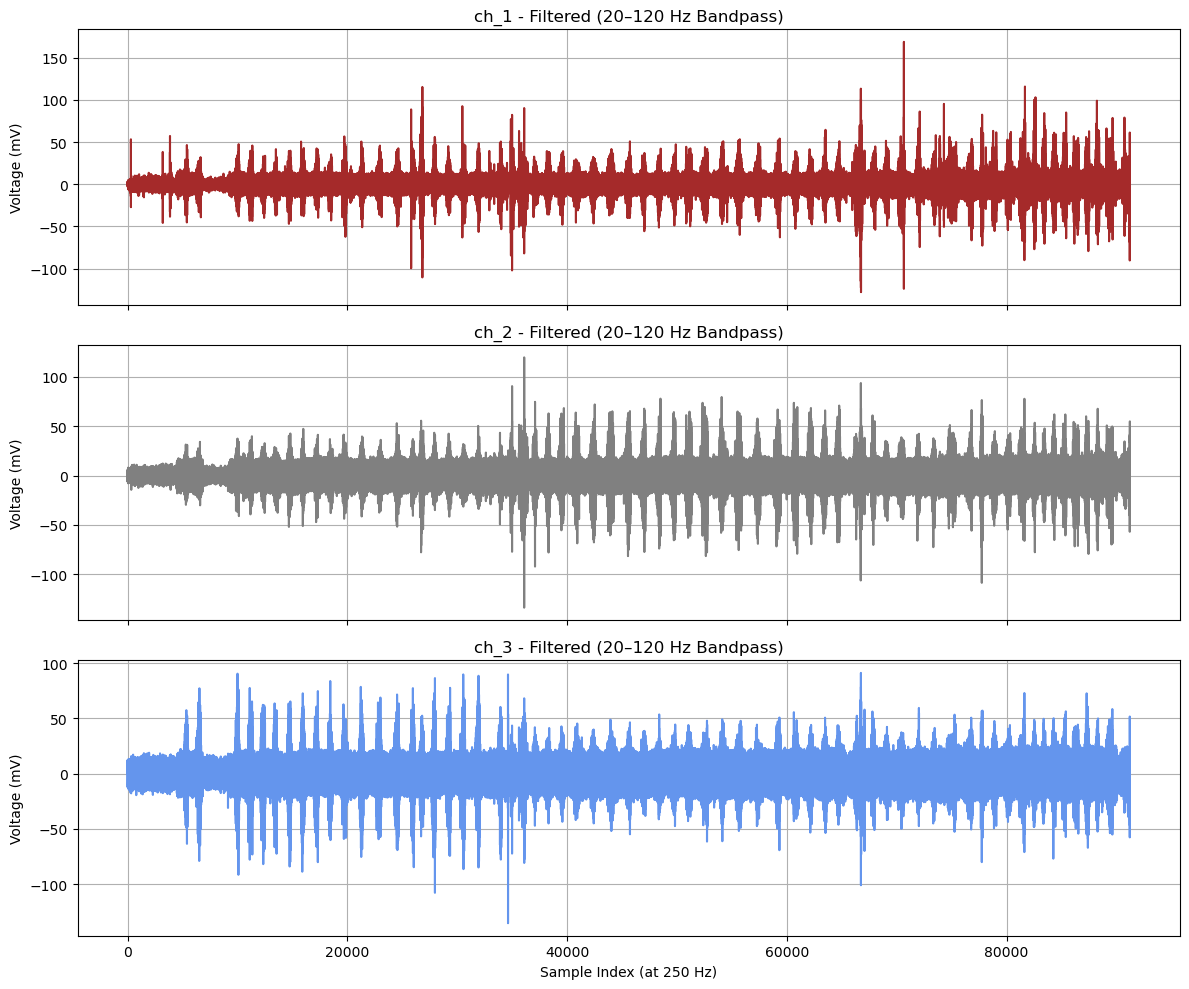

In [38]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt

# ☐☐☐☐ higcut might be a bit low, repeat recording at 500 Hz and raise highcut??
lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filter to each channel
filtered = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    filtered[ch] = bandpass_filter(df[ch][:num_samples])

# ☐☐☐☐ use full wave rectificcation + smoothing or envelope extraction??

# Plot filtered signals
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3']):
    axs[i].plot(filtered[ch], label=f"{ch} (filtered)", color=channel_colors[ch])
    axs[i].set_title(f"{ch} - Filtered ({lowc:.0f}–{highc:.0f} Hz Bandpass)")
    axs[i].set_ylabel("Voltage (mV)")
    axs[i].grid(True)

axs[2].set_xlabel("Sample Index (at 250 Hz)")
plt.tight_layout()
plt.show()

Annotations head
  class     timestamp
0     l  1.748872e+09
1     l  1.748872e+09
2     l  1.748872e+09
3     l  1.748872e+09
4     l  1.748872e+09

EMG head
   ch_0         ch_1         ch_2         ch_3  ch_4  ch_5  ch_6  ch_7  ch_8  \
0   6.0  4005.812586  8168.847343  6832.168321   0.0   0.0   0.0   0.0   0.0   
1   7.0  4005.946697  8173.272988  6844.841760   0.0   0.0   0.0   0.0   0.0   
2   8.0  4005.790234  8174.278816  6848.373335   0.0   0.0   0.0   0.0   0.0   
3   9.0  4003.890336  8167.685052  6839.410286   0.0   0.0   0.0   0.0   0.0   
4  10.0  4000.537574  8163.997014  6826.580385   0.0   0.0   0.0   0.0   0.0   

    ch_9  ...  ch_14  ch_15  ch_16  ch_17  ch_18  ch_19  ch_20  ch_21  \
0 -0.116  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1 -0.114  ...  112.0  254.0  240.0   31.0   96.0    0.0    0.0    0.0   
2 -0.114  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3 -0.114  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

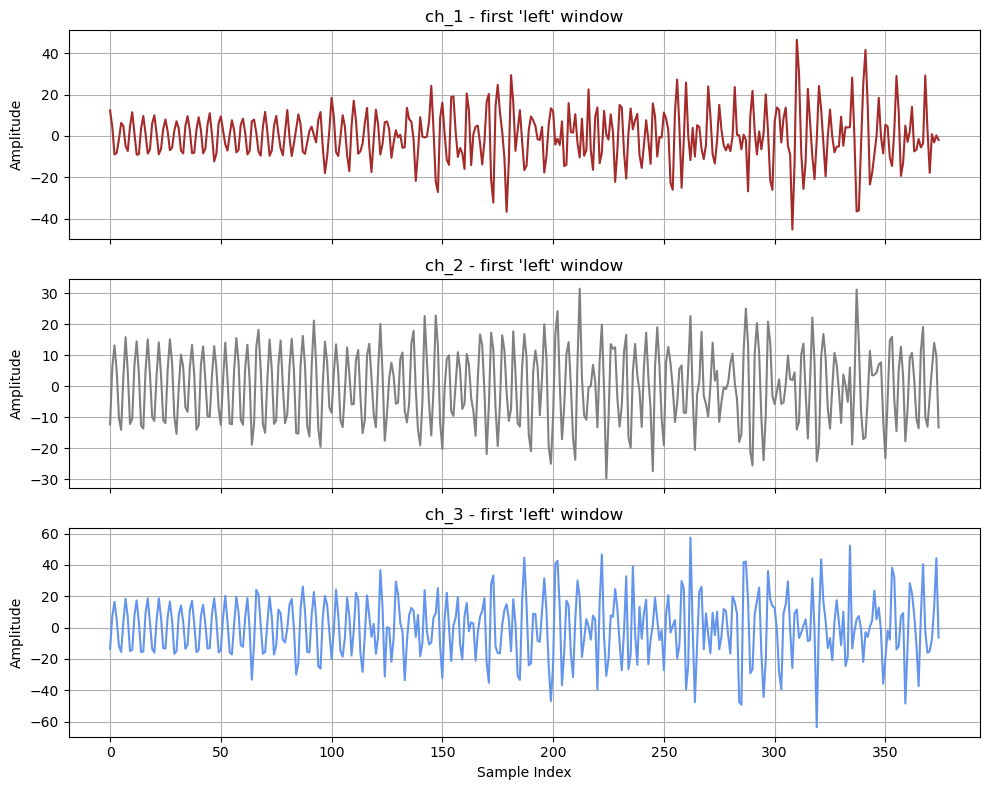

In [43]:
# -------------------------- Windows from the anotations timestamps

import pandas as pd
import numpy as np

# Get annotations
annotations_path = r"C:\Quick_Disk\tonge_emg_xr_project\scripts\data\annotations\annotations1.csv"
annotations = pd.read_csv(annotations_path, header=0, names=['class', 'timestamp'])

# Convert timestamp to numeric (float)
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')

print("Annotations head")
print(annotations.head())
print("\nEMG head")
print(df.head())

# Get EMG data
# ☐☐☐☐ why is the timestamp in channel 22 ?? The official documentation says channel 13
emg_timestamps = df['ch_22']  # Unix timestamps 

# Windows
window_size_seconds = 1.5
windowed_data = {'l': [], 'r': [], 'f': []}  # Dictionary to hold windows by class

for idx, row in annotations.iterrows():
    label = row['class']      # 'l', 'r', or 'f'
    start_time = row['timestamp']
    end_time = start_time + window_size_seconds
    
    # Find indices of samples inside this window
    idxs = (emg_timestamps >= start_time) & (emg_timestamps < end_time)
    
    if not any(idxs):
        # No samples in this window, you can skip or log warning
        print(f"No data for window starting at {start_time} (label={label})")
        continue
    
    # Extract samples for each channel in this window
    window_ch1 = filtered['ch_1'][idxs]
    window_ch2 = filtered['ch_2'][idxs]
    window_ch3 = filtered['ch_3'][idxs]
    
    # Append to dictionary
    windowed_data[label].append({
        'ch_1': window_ch1,
        'ch_2': window_ch2,
        'ch_3': window_ch3,
        'start_time': start_time,
        'end_time': end_time
    })

# Check how many windows per class
print("\nHow many windows per class:")
for c in ['l', 'r', 'f']:
    print(f"Class '{c}' windows: {len(windowed_data[c])}")

# Double check: how many samples in the first window, should be 250
first_window_l = windowed_data['l'][0]
print("\nNumber of samples in first 'l' window:")
print("ch_1:", len(first_window_l['ch_1']))
print("ch_2:", len(first_window_l['ch_2']))
print("ch_3:", len(first_window_l['ch_3']))

# Double check: print first window
first_l_window = windowed_data['l'][0]
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3']):
    axs[i].plot(first_l_window[ch], color=channel_colors[ch])
    axs[i].set_title(f"{ch} - first 'left' window")
    axs[i].grid(True)
    axs[i].set_ylabel("Amplitude")
axs[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()


In [40]:
# -------------------------- Feature extraction

import numpy as np
import pandas as pd

# Feature functions
def rms(signal):
    return np.sqrt(np.mean(signal**2))

#def zero_crossings(signal):
    #signs = np.sign(signal)
    #signs[signs == 0] = -1  # treat zeros as negative to avoid missing crossings
    #return np.sum(np.diff(signs) != 0)
    #return np.sum(np.diff(np.sign(signal)) != 0)

def zero_crossings(signal):
    signs = np.sign(signal)
    # Replace zeros with the previous sign or 1 (to avoid false zero crossings)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)


def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

# Prepare lists to collect features and labels
features = []
labels = []

# Loop over all classes and windows
for label in ['l', 'r', 'f']:
    for window in windowed_data[label]:
        # Extract channel signals
        ch1 = window['ch_1']
        ch2 = window['ch_2']
        ch3 = window['ch_3']
        
        # Compute features per channel
        feats = []
        for ch_signal in [ch1, ch2, ch3]:
            feats.append(rms(ch_signal))
            feats.append(zero_crossings(ch_signal))
            feats.append(waveform_length(ch_signal))
        
        features.append(feats)
        labels.append(label)

# Create column names
cols = []
for ch in ['ch_1', 'ch_2', 'ch_3']:
    for feat_name in ['RMS', 'ZC', 'WL']:
        cols.append(f"{ch}_{feat_name}")

# Create DataFrame
X = pd.DataFrame(features, columns=cols)
y = pd.Series(labels, name='label')

print(X.head())
print(y.head())



    ch_1_RMS  ch_1_ZC      ch_1_WL   ch_2_RMS  ch_2_ZC      ch_2_WL  \
0  10.324444      105  2560.106655  11.775047      100  3017.479048   
1   8.373841      107  2174.092387  10.817819       99  2848.759838   
2  10.337818      102  2510.876577  11.781702      101  2943.067458   
3   7.649380       99  1931.210802  10.755585       99  2849.914223   
4   8.116034      102  2065.716154  12.238015       99  3063.296580   

    ch_3_RMS  ch_3_ZC      ch_3_WL  
0  17.349638      110  4495.013324  
1  15.184355      109  4055.902946  
2  20.306249      110  5220.938863  
3  15.316061      101  3923.985015  
4  19.798366      101  4807.078351  
0    l
1    l
2    l
3    l
4    l
Name: label, dtype: object


SVM Test accuracy: 0.94


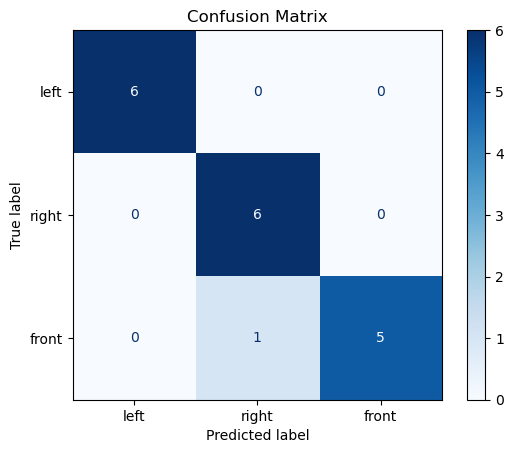

In [53]:
# -------------------------- Classification: SVM

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# 1. Split data (70% train, 30% test), X = features, y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Train clf (classifier)
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# 3. Predict 
y_pred = clf.predict(X_test)

# 4. Evaluate 
acc = accuracy_score(y_test, y_pred)
print(f"SVM Test accuracy: {acc:.2f}")

# 5. Confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=['l','r','f'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'right', 'front'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Radom Forest Test Accuracy: 0.89


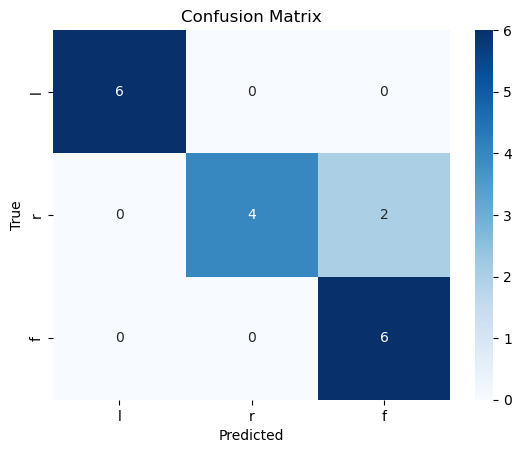

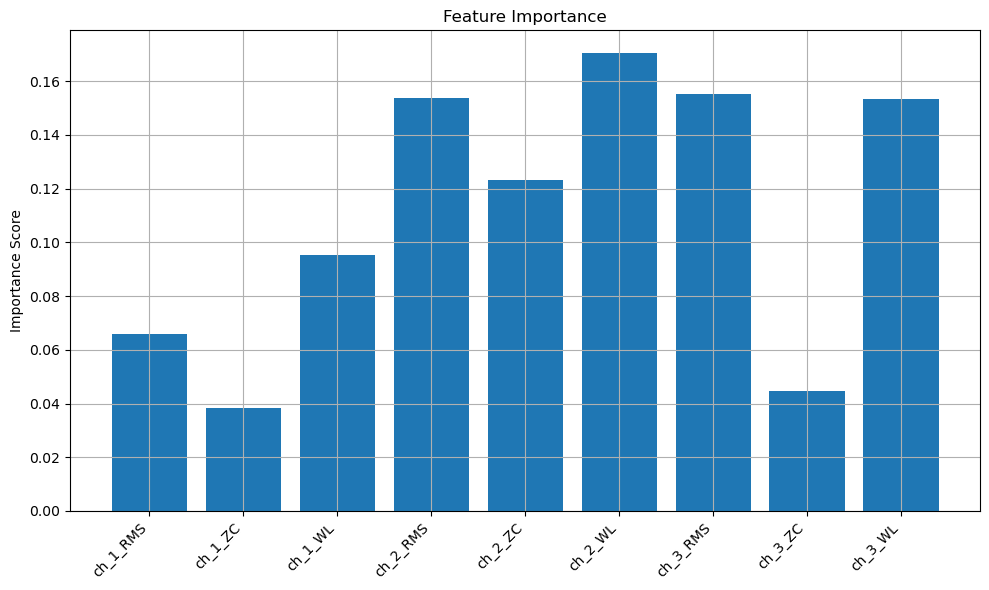

In [59]:
# -------------------------- Classification: Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Train 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predict
y_pred = clf.predict(X_test)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'r', 'f'])

print(f"Radom Forest Test Accuracy: {acc:.2f}")

# 5. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['l', 'r', 'f'], yticklabels=['l', 'r', 'f'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()